In [1]:
import scipy.stats as sts
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.special as sp

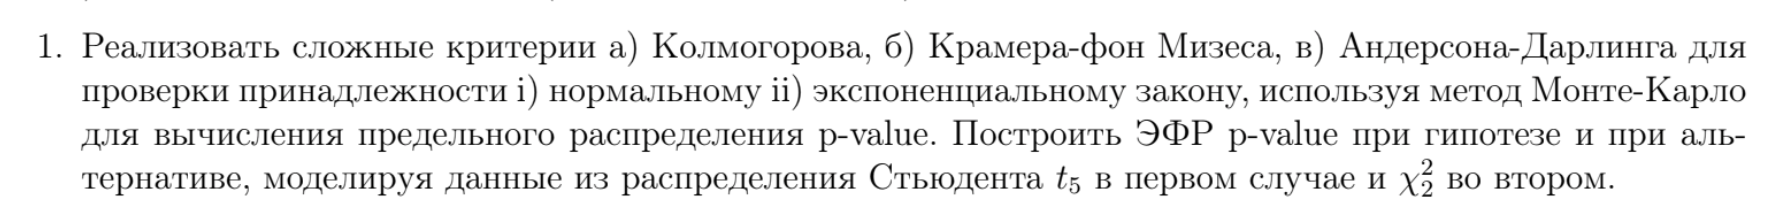

In [2]:
def monte_carlo_test(data, statistic):
    size = len(data)
    pvalue = (data>statistic).sum()/size
    return pvalue

In [3]:
# file = open('ksstat.txt', 'w')
# num_samp = 10000
# size_samp = 2000
# data = sts.expon(loc=0, scale=1).rvs(size=(num_samp,size_samp))
# for i in range(num_samp):
#     print(np.sqrt(size_samp)*sts.kstest(data[i]/(data[i].mean()), sts.expon.cdf).statistic, file = file)
# file.close()

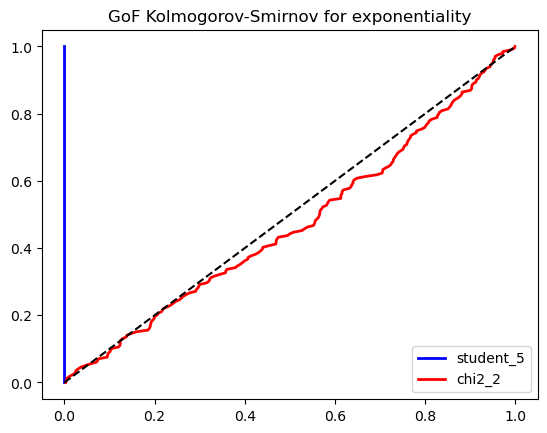

In [4]:
fig, ax = plt.subplots()
plt.title("GoF Kolmogorov-Smirnov for exponentiality")
division_rate = 200
file = open('ksstat.txt', 'r')
data = file.read().splitlines()
file.close()
data = list(map(float, data))
ss = 1000
test_t = sts.t.rvs(size=(division_rate, ss), df=5)
test_chi2 = sts.chi2.rvs(size=(division_rate, ss), df=2)
def get_res_kolm(sample):
    stat = [np.sqrt(ss)*sts.kstest(sample[i]/(sample[i].mean()), sts.expon.cdf).statistic for i  in range(division_rate)]
    result = np.sort(list(map(lambda x: monte_carlo_test(data, x), stat)))
    return result
y = np.linspace(0,1, division_rate)
ax.plot(get_res_kolm(test_t), y, lw = 2, label = "student_5", color = 'blue')
ax.plot(get_res_kolm(test_chi2), y, lw = 2, label = "chi2_2", color = 'red')
ax.plot(y,y, linestyle='dashed', c='black')
ax.legend()

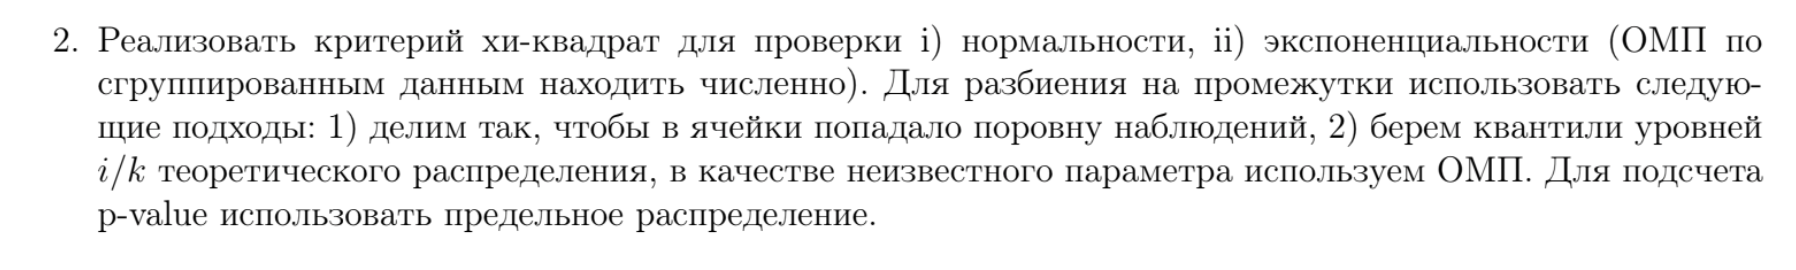

In [5]:
def get_f_obs(data, percentiles):
    f_obs = []
    size = len(percentiles)
    for j in range(size):
        if j == 0:
            compare = data < percentiles[0]
            f_obs.append(sum(compare))
        else: 
            compare = [percentiles[j-1] <= x < percentiles[j] for x in data]
            f_obs.append(sum(compare))
    compare = data >= percentiles[size-1]
    f_obs.append(sum(compare))
    return f_obs

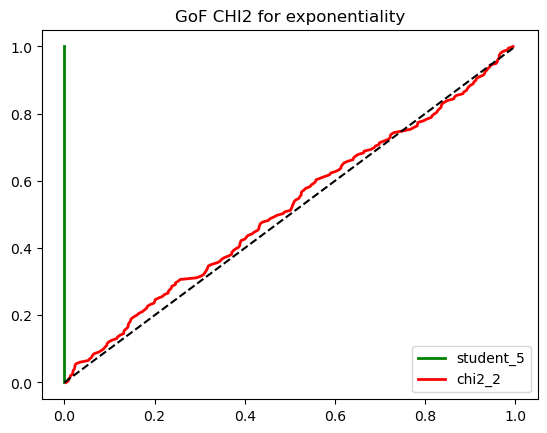

In [109]:
fig, ax = plt.subplots()
plt.title("GoF CHI2 for exponentiality")
ss = 500
df = math.floor(math.log2(ss))
division = [j/df for j in range(1,df)]
division_rate = 200
f_exp = [ss * 1/df for j in range(df)]
test_t = sts.t.rvs(size=(division_rate, ss), df=5)
test_chi2 = sts.chi2.rvs(size=(division_rate, ss), df=2)
percentiles = [sts.expon.ppf(j) for j in division]
def get_res_chi2(sample):
    sample_fixed = [sample[i]/(sample[i].mean()) for i in range(division_rate)]
    f_obs = [get_f_obs(sample_fixed[i], percentiles) for i in range(division_rate)]
    result = np.sort([sts.chisquare(f_exp, f_obs[i], ddof = 1).pvalue for i in range(division_rate)])
    return result
y = np.linspace(0,1, division_rate)
ax.plot(get_res_chi2(test_t), y, lw = 2, label = "student_5", color = 'green')
ax.plot(get_res_chi2(test_chi2), y, lw = 2, label = "chi2_2", color = 'red')
ax.plot(y,y, linestyle='dashed', c='black')
ax.legend()

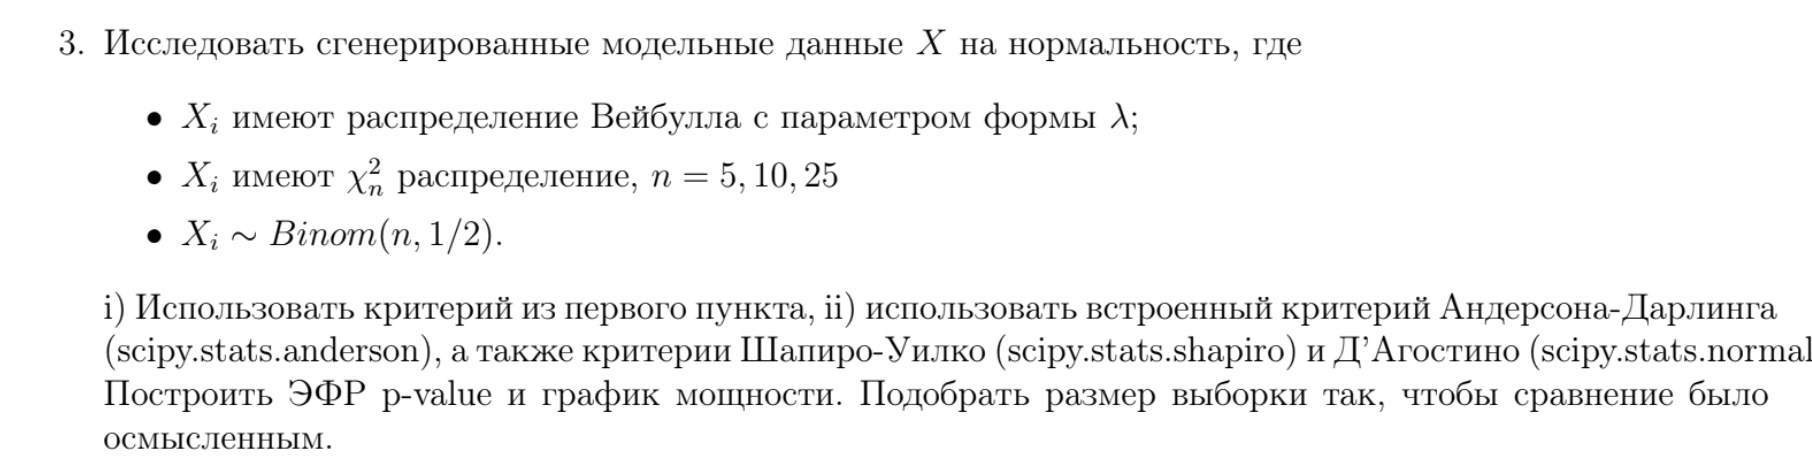

In [7]:
file = open('ad_gof.txt', 'w')
num_samp = 10000
size_samp = 2000
data = sts.norm(loc=0, scale=1).rvs(size=(num_samp,size_samp))
for i in range(num_samp):
    print(sts.anderson((data[i]-data[i].mean())/data[i].std()).statistic, file = file)
file.close()

In [8]:
file = open('ad_gof.txt', 'r')
data = file.read().splitlines()
file.close()
data = list(map(float, data))
division_rate = 100
ss = 50
alpha = 0.05
def task(distr, name, param):
    if distr == sts.weibull_min:
        test_param = np.linspace(0.1,20,50)
        example = distr(param)
    elif distr == sts.chi2:
        test_param = np.arange(1, 50, 1)
        example = distr(param)
    elif distr == sts.binom:
        distr = lambda x: sts.binom(x, p = 1/2)
        test_param = np.arange(5,250,5)
        example = distr(param)
    sample = example.rvs(size=(division_rate, ss))
    fig, ax = plt.subplots(1,2)
    plt.suptitle(name)
    stat1 = [sts.anderson((sample[i]-sample[i].mean())/sample[i].std()).statistic for i  in range(division_rate)]
    result1 = np.sort(list(map(lambda x: monte_carlo_test(data, x), stat1)))
    result2 = np.sort([sts.shapiro(sample[i]).pvalue for i  in range(division_rate)])
    result3 = np.sort([sts.normaltest(sample[i]).pvalue for i  in range(division_rate)])
    y = np.linspace(0,1, division_rate)
    ax[0].set_title("p-value ECDF")
    ax[0].plot(result1, y, lw = 2, label = "AD")
    ax[0].plot(result2, y, lw = 2, label = "SW")
    ax[0].plot(result3, y, lw = 2, label = "DA")
    ax[0].plot(y,y, linestyle='dashed', c='black')
    ax[0].legend()
    fig.tight_layout()
    power1 = []
    power2 = []
    power3 = []
    for param in test_param:
        sample = distr(param).rvs(size=(division_rate, ss))
        stat1 = [sts.anderson((sample[i]-sample[i].mean())/sample[i].std()).statistic for i  in range(division_rate)]
        result1 = np.sort(list(map(lambda x: monte_carlo_test(data, x), stat1)))
        result2 = np.sort([sts.shapiro(sample[i]).pvalue for i  in range(division_rate)])
        result3 = np.sort([sts.normaltest(sample[i]).pvalue for i  in range(division_rate)])
         
        check1= np.array(result1) < alpha
        power1.append(sum(check1)/division_rate)
        
        check2= np.array(result2) < alpha
        power2.append(sum(check2)/division_rate)
        
        check3= np.array(result3) < alpha
        power3.append(sum(check3)/division_rate)

    ax[1].set_title("Power")
    ax[1].plot(test_param, power1, lw = 2, label = "AD")
    ax[1].plot(test_param, power2, lw = 2, label = "SW")
    ax[1].plot(test_param, power3, lw = 2, label = "DA")
    ax[1].legend()

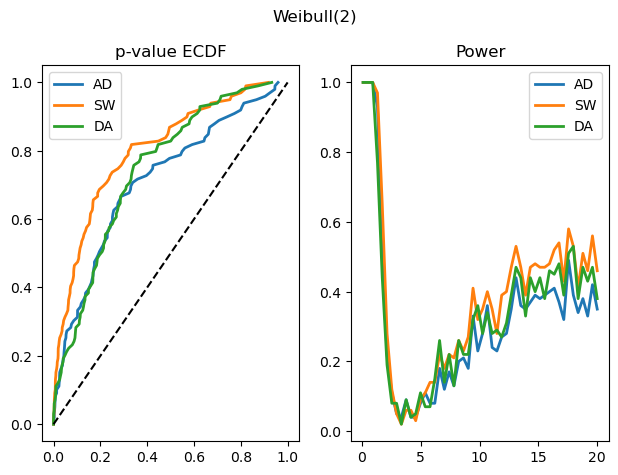

In [9]:
lambda_ = 2
name = f"Weibull({lambda_})"
task(sts.weibull_min, name, lambda_)

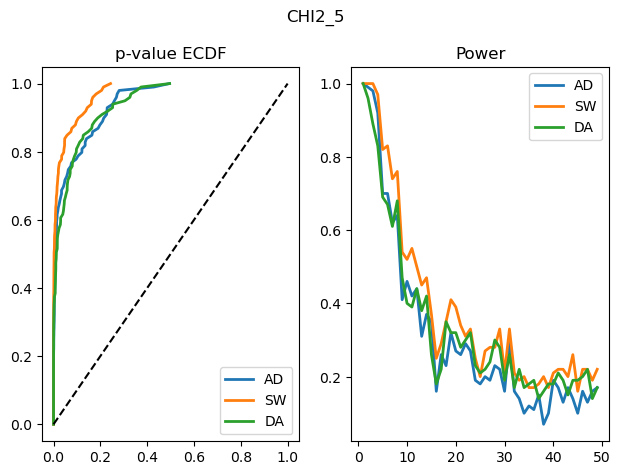

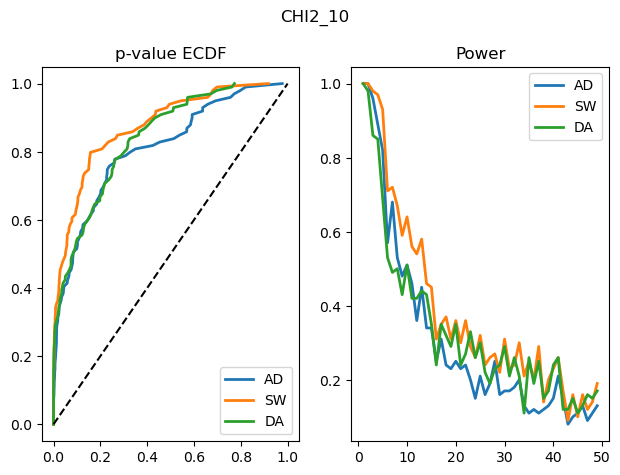

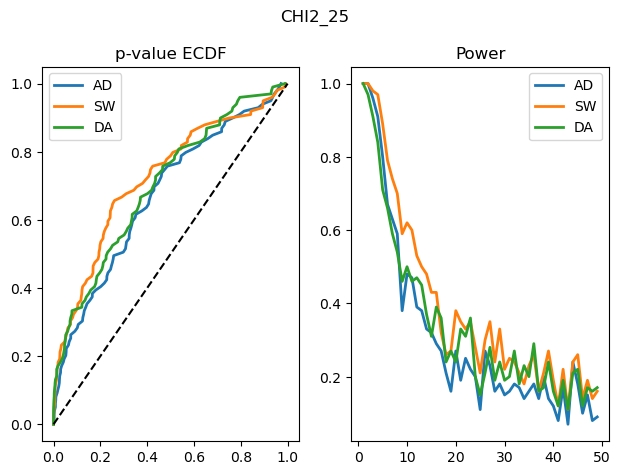

In [10]:
for df in [5,10,25]:
    name = f"CHI2_{df}"
    task(sts.chi2, name, df)

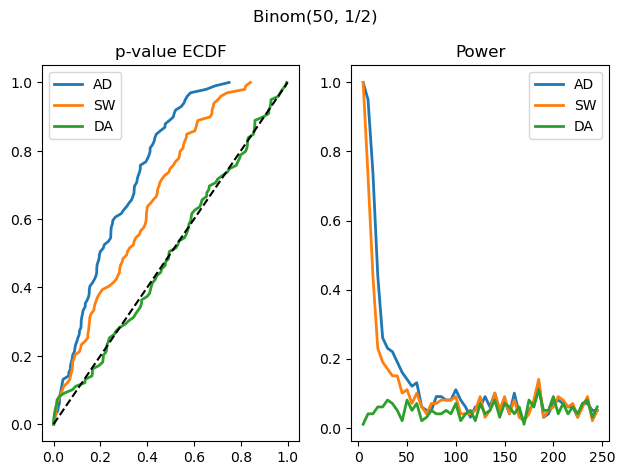

In [11]:
n_test = 50
name = f"Binom({n_test}, 1/2)"
task(sts.binom, name, n_test)

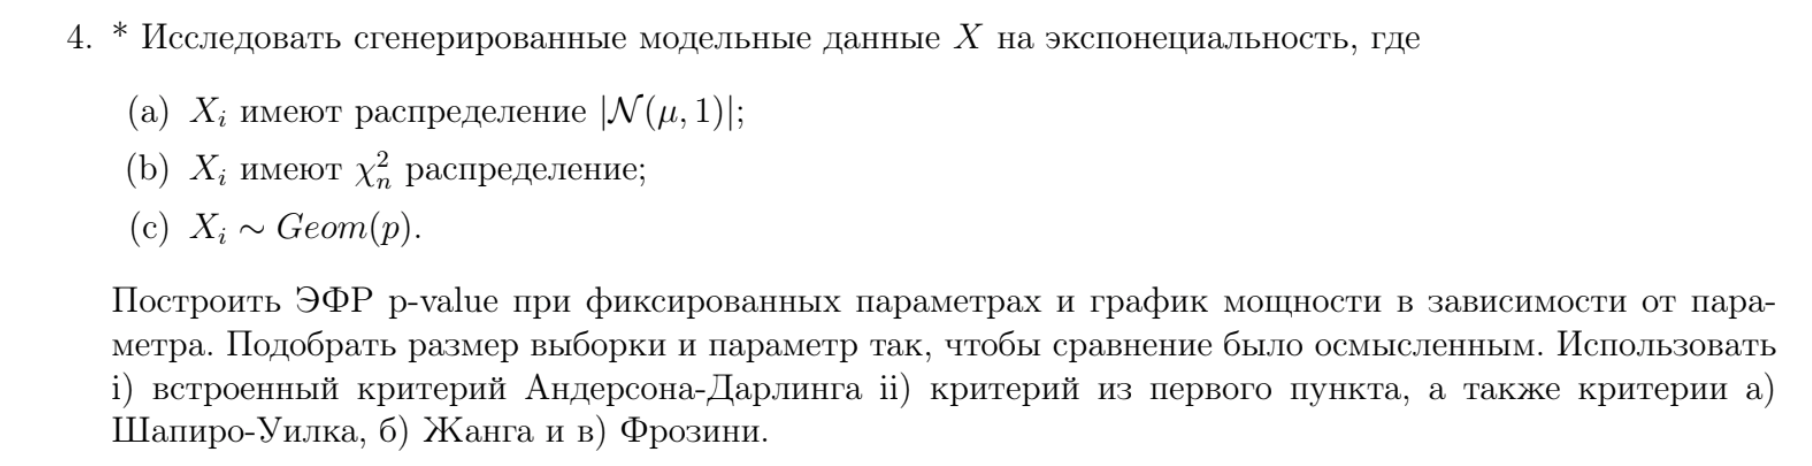

In [96]:
def shapiro_stat(data:np.array):
    size = len(data)
    data.sort()
    mean = data.mean()
    num = (data[0]-mean)**2 * size
    den = (size-1)*(sum((data-mean)**2))+1e-4
    stat = num/den
    return stat

In [97]:
def get_shapiro_pvals(data): #data is 2darray
    num_samp = 10000
    num_given_samp = len(data)
    ss = len(data[0]) # assuming equal sizes of samples in data
    rvs = sts.expon(loc=0, scale=1).rvs(size=(num_samp,ss))
    test_results = [shapiro_stat(rvs[i]) for i  in range(num_samp)]
    data_results = [shapiro_stat(data[i]) for i  in range(num_given_samp)]
    pvals = np.sort(list(map(lambda x: monte_carlo_test(test_results, x), data_results)))
    return pvals

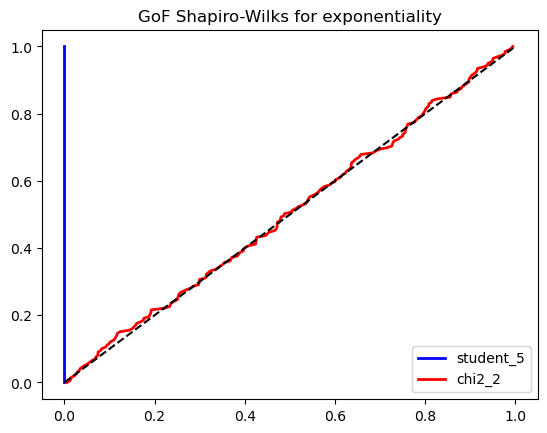

In [36]:
fig, ax = plt.subplots()
plt.title("GoF Shapiro-Wilks for exponentiality")
division_rate = 200
ss = 100
test_t = sts.t.rvs(size=(division_rate, ss), df=5)
test_chi2 = sts.chi2.rvs(size=(division_rate, ss), df=2)
y = np.linspace(0,1, division_rate)
ax.plot(get_shapiro_pvals(test_t), y, lw = 2, label = "student_5", color = 'blue')
ax.plot(get_shapiro_pvals(test_chi2), y, lw = 2, label = "chi2_2", color = 'red')
ax.plot(y,y, linestyle='dashed', c='black')
ax.legend()

In [98]:
file = open('ksstat.txt', 'r')
data1 = file.read().splitlines()
file.close()
data1 = list(map(float, data1))
division_rate = 100
alpha = 0.05
def task4(distr, name, param, ss):
    if distr == sts.foldnorm:
        test_param = np.linspace(0,1,20)
        example = distr(param)
    elif distr == sts.chi2:
        test_param = np.arange(1, 50, 1)
        example = distr(param)
    elif distr == sts.geom:
        test_param = np.linspace(0.01,0.99,20)
        example = distr(param)
    sample = example.rvs(size=(division_rate, ss))
    fig, ax = plt.subplots(1,2)
    plt.suptitle(name)
    stat1 = [np.sqrt(ss)*sts.kstest(sample[i]/(sample[i].mean()), sts.expon.cdf).statistic for i  in range(division_rate)]
    result1 = np.sort(list(map(lambda x: monte_carlo_test(data1, x), stat1))) # это я достану колмогорова
    result2 = get_shapiro_pvals(sample)
    y = np.linspace(0,1, division_rate)
    ax[0].set_title("p-value ECDF")
    ax[0].plot(result1, y, lw = 2, label = "KOLM")
    ax[0].plot(result2, y, lw = 2, label = "SW")
    ax[0].plot(y,y, linestyle='dashed', c='black')
    ax[0].legend()
    fig.tight_layout()
    power1 = []
    power2 = []
    for param in test_param:
        sample = distr(param).rvs(size=(division_rate, ss))
        stat1 = [np.sqrt(ss)*sts.kstest(sample[i]/(sample[i].mean()), sts.expon.cdf).statistic for i  in range(division_rate)]
        result1 = np.sort(list(map(lambda x: monte_carlo_test(data1, x), stat1)))
        result2 = get_shapiro_pvals(sample)
    
        check1= np.array(result1) < alpha
        power1.append(sum(check1)/division_rate)
        
        check2= np.array(result2) < alpha
        power2.append(sum(check2)/division_rate)

    ax[1].set_title("Power")
    ax[1].plot(test_param, power1, lw = 2, label = "KOLM")
    ax[1].plot(test_param, power2, lw = 2, label = "SW")
    ax[1].legend()

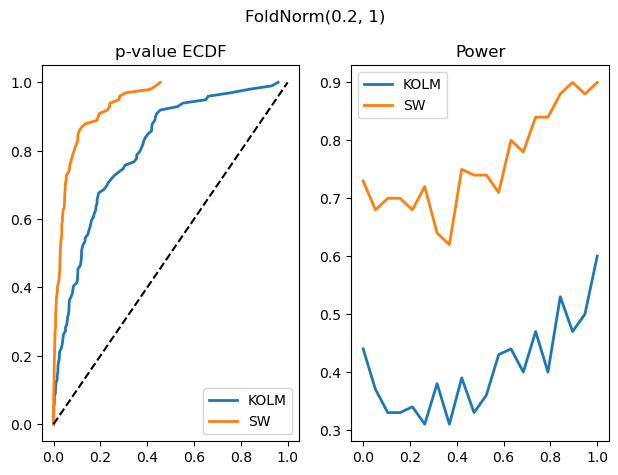

In [44]:
mu_test = 0.2
name = f"FoldNorm({mu_test}, 1)"
task4(sts.foldnorm, name, mu_test, 50)

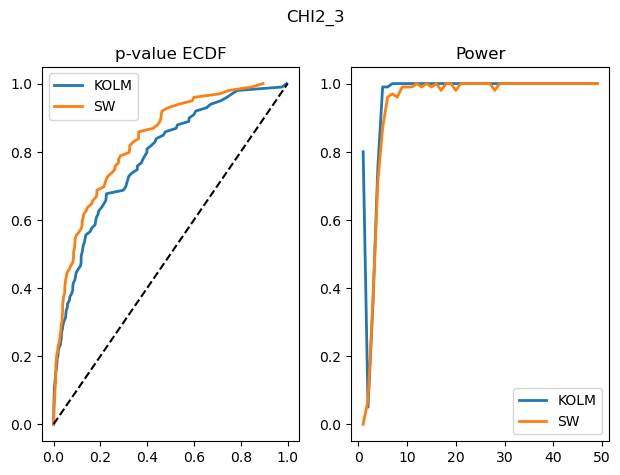

In [46]:
df_test = 3
name = f"CHI2_{df_test}"
task4(sts.chi2, name, df_test, 50)

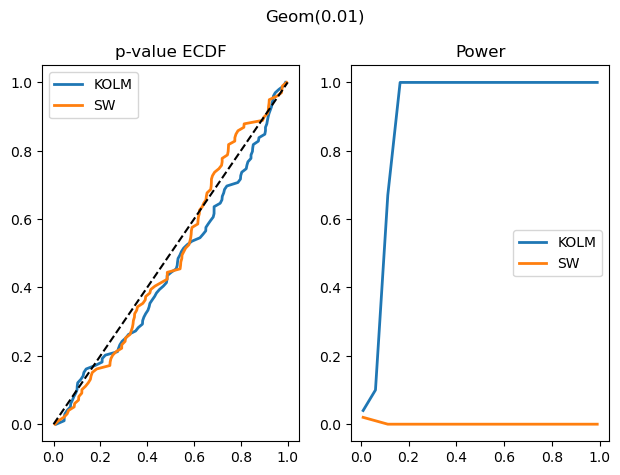

In [106]:
p_test = 0.01
name = f"Geom({p_test})"
task4(sts.geom, name, p_test, 100)